# LoRa Data Analysis - UCB vs. TS


We first declare a fixed parameters.

Those parameters are not changed during the experiments.

Fixed communication parameters are listed below:
- Code Rate: 4/5
- Frequency: 866.1 MHz
- Bandwidth: 125 kHz

End nodes:
- were sending different types of uplink messages
- were sending a single message each 2 minutes
- comparison of upper confidence bound algorithm (UCB) and Thompson sampling (TS)

Access points:
- only a single access point was used
- capture effect was also considered

Initial declaration

In [1]:
%matplotlib inline
import pandas as pd # import pandas
import numpy as np # import numpy
import matplotlib as mpl # import matplotlib
import matplotlib_inline as mpl_inl # import matplotlib_inline
import matplotlib.pyplot as plt # import plotting module
import statistics
import math
import base64
from IPython.display import set_matplotlib_formats # module for svg export

# Set output format for png figures
output_format = 'png'
mpl_inl.backend_inline.set_matplotlib_formats(output_format) # set export to svg file

ts_uplink_file = 'ts_uplink_messages.csv'
ucb_uplink_file = 'ucb_uplink_messages.csv'

## Analysis of Uplink Messages

We read a csv file with uplink messages

In [2]:
ts_uplink_messages = pd.read_csv(ts_uplink_file, delimiter=',')
ucb_uplink_messages = pd.read_csv(ucb_uplink_file, delimiter=',')

Let us have a look at various columns that are present and can be evaluated.

In [3]:
ts_uplink_messages.head()

,id,app_data,snr,rssi,duty_cycle_remaining,is_primary,receive_time,seq,frequency,spf,power,airtime,coderate,bandwidth,msg_group_number,message_type_id,ap_id,node_id
0,127284,MTUwNy44LDcyODcuMg==,-14.5,-99.8,36000,t,2021-04-19 08:51:10.805,1,866100000,12,10,1294,4/5,125000,249,1,bbbbbb,OFeD
1,127285,MzM0NS4zLDY4NjkuNA==,4.3,-89.6,36000,t,2021-04-19 08:51:16.354,1,866100000,8,10,102,4/5,125000,405,1,bbbbbb,7wPG
2,127286,NDU5OC45LDQxMjEuMg==,-19.7,-66.6,36000,t,2021-04-19 08:51:21.894,1,866100000,9,14,183,4/5,125000,284,1,bbbbbb,LPcK
3,127287,MjE3OS4yLDE4OTguMg==,5.8,-99.9,36000,t,2021-04-19 08:51:26.936,1,866100000,11,10,714,4/5,125000,98,1,bbbbbb,pAEx
4,127288,ODk5Ny4xLDE5MjguMg==,0.6,-99.6,36000,t,2021-04-19 08:51:31.424,1,866100000,8,14,102,4/5,125000,326,2,bbbbbb,DPPo


In [4]:
ucb_uplink_messages.head()

,id,app_data,snr,rssi,duty_cycle_remaining,is_primary,receive_time,seq,frequency,spf,power,airtime,coderate,bandwidth,msg_group_number,message_type_id,ap_id,node_id
0,102854,NzA3Ni44LDEzNTkuMQ==,2.5,-99.9,36000,t,2021-04-10 09:40:22.512,1,866100000,7,10,58,4/5,125000,124,1,111111,t3w0
1,102855,NTc4My4zLDQ5MDkuNw==,-17.4,-66.5,36000,t,2021-04-10 09:40:27.567,1,866100000,7,10,58,4/5,125000,111,2,111111,j6eI
2,102856,NzU4LjgsNjEzNS43,-12.6,-100.8,36000,t,2021-04-10 09:40:32.565,1,866100000,7,10,52,4/5,125000,155,2,111111,Qihc
3,102857,Njc2NC45LDMwNjAuMg==,-12.6,-90.5,36000,t,2021-04-10 09:40:38.065,1,866100000,7,10,58,4/5,125000,193,1,111111,iOK8
4,102858,OTExMy4xLDI4OTAuOA==,-17.6,-101.9,36000,t,2021-04-10 09:40:43.606,1,866100000,7,10,58,4/5,125000,252,1,111111,96VU


Remove all columns that have fixed values or there is no point in their analysis.

### Payload Length

In [7]:
ts_uplink_messages['payload_len'] = ts_uplink_messages.app_data.apply(len)
ucb_uplink_messages['payload_len'] = ucb_uplink_messages.app_data.apply(len)

In [8]:
ts_payload_len = round(statistics.mean(ts_uplink_messages.payload_len))
ucb_payload_len = round(statistics.mean(ucb_uplink_messages.payload_len))

print(f'Mean value of payload length for TS is {ts_payload_len} B')
print(f'Mean value of payload length for UCB is {ucb_payload_len} B')

Mean value of payload length for TS is 43 B
Mean value of payload length for UCB is 43 B


### Spreading Factor

In [9]:
sf1 = ts_uplink_messages.spf.value_counts()
sf2 = ucb_uplink_messages.spf.value_counts()

diff = abs(sf1 - sf2)
diff.fillna(0)
sf_ts = [sf1, diff]
sf_ts = pd.concat(sf_ts, axis=1, sort=False).sum(axis=1)
sf_ts.sort_index(ascending=False, inplace=True)

diff = abs(sf2 - sf1)
diff.fillna(0)
sf_ucb = [sf2, diff]
sf_ucb = pd.concat(sf_ucb, axis=1, sort=False).sum(axis=1)
sf_ucb.sort_index(ascending=False, inplace=True)

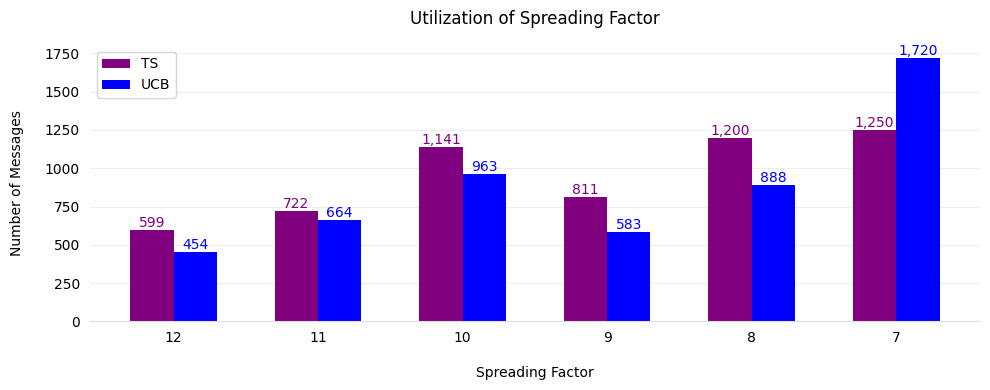

In [24]:
# Create a grouped bar chart, with job as the x-axis
# and gender as the variable we're grouping on so there
# are two bars per job.
fig, ax = plt.subplots(figsize=(10, 4))

# Define bar width. We need this to offset the second bar.
bar_width = 0.3
index = np.arange(len(sf_ts))

ax.bar(index, sf_ts, width=bar_width, color='purple', label = 'TS')
# Same thing, but offset the x.
ax.bar(index + bar_width, sf_ucb, width=bar_width, color='blue', label = 'UCB')

# Fix the x-axes.
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(sf_ucb.index)

# Add legend.
ax.legend()

# Axis styling.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add axis and chart labels.
ax.set_xlabel('Spreading Factor', labelpad=15)
ax.set_ylabel('Number of Messages', labelpad=15)
ax.set_title('Utilization of Spreading Factor', pad=15)

fig.tight_layout()

# For each bar in the chart, add a text label.
for bar in ax.patches:
  # The text annotation for each bar should be its height.
  bar_value = round(bar.get_height())
  # Format the text with commas to separate thousands. You can do
  # any type of formatting here though.
  text = f'{bar_value:,}'
  # This will give the middle of each bar on the x-axis.
  text_x = bar.get_x() + bar.get_width() / 2
  # get_y() is where the bar starts so we add the height to it.
  text_y = bar.get_y() + bar_value
  # If we want the text to be the same color as the bar, we can
  # get the color like so:
  bar_color = bar.get_facecolor()
  # If you want a consistent color, you can just set it as a constant, e.g. #222222
  ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color, size=10)
    
fig.savefig(f'ts-ucb-sf.{output_format}', dpi=300)

All nodes used the same frequency to increase a probability of collisions.

We have only a single Access Point.

## Analysis of End Nodes

Analysis of certain aspects (active time, sleep time and collisions) of end devices.

In [11]:
ts_unique_ens = ts_uplink_messages.node_id.nunique()
ucb_unique_ens = ucb_uplink_messages.node_id.nunique()

print(f'Number of end nodes participating for TS is {ts_unique_ens}.')
print(f'Number of end nodes participating for UCB is {ucb_unique_ens}.')

Number of end nodes participating for TS is 97.
Number of end nodes participating for UCB is 88.


In [12]:
ts_end_nodes = pd.read_csv(f'ts_end_nodes.csv', delimiter=',')
ucb_end_nodes = pd.read_csv(f'ucb_end_nodes.csv', delimiter=',')

### Collision Ratio

In [13]:
ts_collisions = ts_end_nodes.collisions
ucb_collisions = ucb_end_nodes.collisions

ts_max_collisions = max(ts_end_nodes.collisions)
ts_min_collisions = min(ts_end_nodes.collisions)
ucb_max_collisions = max(ucb_end_nodes.collisions)
ucb_min_collisions = min(ucb_end_nodes.collisions)

max_collisions = max(ts_max_collisions, ucb_max_collisions)
min_collisions = min(ts_min_collisions, ucb_min_collisions)
range_collisions = max_collisions - min_collisions
buckets = 12
increment = range_collisions / buckets

print(f'Max number of collisions for TS: {ts_max_collisions}')
print(f'Min number of collisions for TS: {ts_min_collisions}')
print(f'Max number of collisions for UCB: {ucb_max_collisions}')
print(f'Min number of collisions for UCB: {ucb_min_collisions}')

Max number of collisions for TS: 25
Min number of collisions for TS: 0
Max number of collisions for UCB: 22
Min number of collisions for UCB: 0


In [14]:
out_ts = ts_collisions[ts_collisions <= 15]
ts_collision_count = out_ts.value_counts(sort=False)
out_ucb = ucb_collisions[ucb_collisions <= 15]
ucb_collision_count = out_ucb.value_counts(sort=False)

diff = abs(ts_collision_count - ucb_collision_count)
diff.fillna(0)
ts_values = [ts_collision_count, diff]
ts_values = pd.concat(ts_values, axis=1, sort=False).sum(axis=1)
ts_values.sort_index(ascending=False, inplace=True)

diff = abs(ucb_collision_count - ts_collision_count)
diff.fillna(0)
ucb_values = [ucb_collision_count, diff]
ucb_values = pd.concat(ucb_values, axis=1, sort=False).sum(axis=1)
ucb_values.sort_index(ascending=False, inplace=True)

Three highest values with are omitted for clarity (only 1 device each)


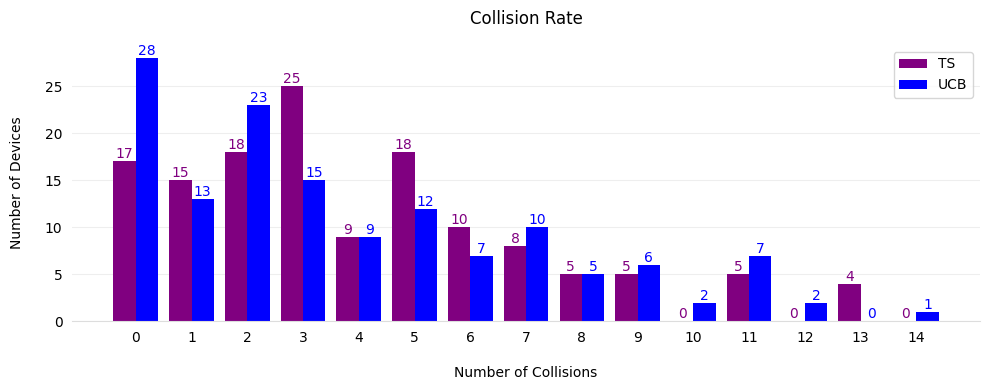

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))

bar_width = 0.4
#index = np.arange(buckets)
#bins = []

#for i in range(buckets + 1):
#    bins.append(round(min_collisions + i * increment))

#out_ts = pd.cut(ts_collisions, bins=bins)
#ts_values = out_ts.value_counts(sort=False).iloc[::-1]

#out_ucb = pd.cut(ucb_collisions, bins=bins)
#ucb_values = out_ucb.value_counts(sort=False).iloc[::-1]

ax.bar(ts_values.index, ts_values, width=bar_width, color='purple', label='TS')
ax.bar(ts_values.index + bar_width, ucb_values, width=bar_width, color='blue', label='UCB')

ax.set_xticks(ts_values.index + bar_width / 2)
ax.set_xticklabels(ts_values.index)

ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xlabel('Number of Collisions', labelpad=15)
ax.set_ylabel('Number of Devices', labelpad=15)
ax.set_title('Collision Rate', pad=15)

fig.tight_layout()

for bar in ax.patches:
  bar_value = round(bar.get_height())
  text = f'{bar_value:,}'
  text_x = bar.get_x() + bar.get_width() / 2
  text_y = bar.get_y() + bar_value
  bar_color = bar.get_facecolor()
  ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color, size=10)
    
fig.savefig(f'ts-ucb-collisions.{output_format}', dpi=300)
print(f'Three highest values with are omitted for clarity (only 1 device each)')

In [16]:
print(f'Mean collision number for TS is {round(statistics.mean(ts_collisions))}')
print(f'Mean collision number for UCB is {round(statistics.mean(ucb_collisions))}')

Mean collision number for TS is 5
Mean collision number for UCB is 4


### Ration between active time and total nodes uptime

In [17]:
ts_energy = (ts_end_nodes.active_time / ts_end_nodes.uptime)
ts_active_time = round(statistics.mean(ts_energy) * 100, 2)
ucb_energy = (ucb_end_nodes.active_time / ucb_end_nodes.uptime)
ucb_active_time = round(statistics.mean(ucb_energy) * 100, 2)

print(f'TS nodes spent {ts_active_time}% of their uptime in active mode')
print(f'UCB nodes spent {ucb_active_time}% of their uptime in active mode')

TS nodes spent 3.03% of their uptime in active mode
UCB nodes spent 2.5% of their uptime in active mode


### Packet Delivery Ratio (PDR)

Evaluation of packet delivery ratio for end nodes.

Add message count from uplink data and collisions.

In [18]:
ucb_data = ucb_uplink_messages.node_id.value_counts()
ucb_nodes = pd.DataFrame({}, columns = ['dev_id', 'collisions', 'messages'])

collisions = []
messages = []
dev_id = []

for index,value in ucb_data.items():
    dev_id.append(index)
    collision_count = ucb_end_nodes.loc[ucb_end_nodes.dev_id == index].collisions.values[0]
    collisions.append(collision_count)
    messages.append(value + collision_count)

ucb_nodes['dev_id'] = dev_id
ucb_nodes['collisions'] = collisions
ucb_nodes['messages'] = messages

In [19]:
ts_end_nodes['pdr'] = round((1 - (ts_end_nodes.collisions / ts_end_nodes.messages))*100, 2)
ts_mean_pdr = round(statistics.mean(ts_end_nodes.pdr), 2)

ucb_nodes['pdr'] = round((1 - (ucb_nodes.collisions / ucb_nodes.messages))*100, 2)
ucb_mean_pdr = round(statistics.mean(ucb_nodes.pdr), 2)

print(f'Mean value of PDR for TS is {ts_mean_pdr}%')
print(f'Mean value of PDR for UCB is {ucb_mean_pdr}%')

Mean value of PDR for TS is 97.69%
Mean value of PDR for UCB is 80.85%


In [20]:
ts_max_pdr = max(ts_end_nodes.pdr)
ts_min_pdr = min(ts_end_nodes.pdr)
ucb_max_pdr = max(ucb_nodes.pdr)
ucb_min_pdr = min(ucb_nodes.pdr)

max_pdr = max(ts_max_pdr, ucb_max_pdr)
min_pdr = min(ts_min_pdr, ucb_min_pdr)
range_pdr = max_pdr - min_pdr
buckets = 12
increment = math.ceil(range_pdr / buckets)

print(f'Max PDR for TS: {ts_max_pdr}%')
print(f'Min PDR for TS: {ts_min_pdr}%')
print(f'Max PDR for UCB: {ucb_max_pdr}%')
print(f'Min PDR for UCB: {ucb_min_pdr}%')

Max PDR for TS: 100.0%
Min PDR for TS: 86.26%
Max PDR for UCB: 100.0%
Min PDR for UCB: 9.09%


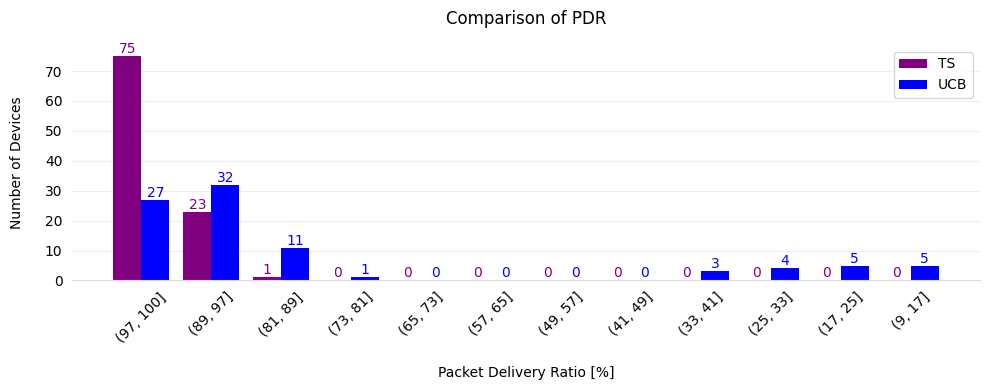

In [21]:
fig, ax = plt.subplots(figsize=(10, 4))
bins = []
bar_width = 0.4
index = np.arange(buckets)

for i in range(buckets + 1):
    bins.append(min(round(min_pdr + i * increment), 100))

out_ts = pd.cut(ts_end_nodes.pdr, bins=bins)
ts_values = out_ts.value_counts(sort=False).iloc[::-1]

out_ucb = pd.cut(ucb_nodes.pdr, bins=bins)
ucb_values = out_ucb.value_counts(sort=False).iloc[::-1]

ax.bar(index, ts_values, width=bar_width, color='purple', label='TS')
ax.bar(index + bar_width, ucb_values, width=bar_width, color='blue', label='UCB')

ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(ts_values.index, rotation=45)

ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xlabel('Packet Delivery Ratio [%]', labelpad=15)
ax.set_ylabel('Number of Devices', labelpad=15)
ax.set_title('Comparison of PDR', pad=15)

fig.tight_layout()

for bar in ax.patches:
  bar_value = round(bar.get_height())
  text = f'{bar_value:,}'
  text_x = bar.get_x() + bar.get_width() / 2
  text_y = bar.get_y() + bar_value
  bar_color = bar.get_facecolor()
  ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color, size=10)

fig.savefig(f'ts-ucb-pdr.{output_format}', dpi=300)

## Path of Each End Node

Data about position are encoded as base64.

Decode base64, extract position and save the results to original data frame.

In [22]:
# Extracting X and Y coordinates from payload
ts_app_data = ts_uplink_messages.app_data.apply(base64.b64decode)
ts_app_data = ts_app_data.astype(str)
ts_app_data = ts_app_data.str.split(',')

df = pd.DataFrame({}, columns = ['node_id', 'x', 'y'])
x = []
y = []

for row in ts_app_data:
    x.append(round(float(row[1].split('\'')[0]), 2) / 1000)
    y.append(round(float(row[0].split('\'')[1]), 2) / 1000)

ts_uplink_messages['x'] = x
ts_uplink_messages['y'] = y

# Same for the second algorithm
ucb_app_data = ucb_uplink_messages.app_data.apply(base64.b64decode)
ucb_app_data = ucb_app_data.astype(str)
ucb_app_data = ucb_app_data.str.split(',')

df = pd.DataFrame({}, columns = ['node_id', 'x', 'y'])
x = []
y = []

for row in ucb_app_data:
    x.append(round(float(row[1].split('\'')[0]), 2) / 1000)
    y.append(round(float(row[0].split('\'')[1]), 2) / 1000)

ucb_uplink_messages['x'] = x
ucb_uplink_messages['y'] = y

IndexError: list index out of range

Now, we draw a path for each end node based on the received coordinates.

/tmp/ipykernel_15715/2324166417.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ts_cmap = mpl.cm.get_cmap('RdPu')
/tmp/ipykernel_15715/2324166417.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ucb_cmap = mpl.cm.get_cmap('PuBu')


AttributeError: 'DataFrame' object has no attribute 'x'

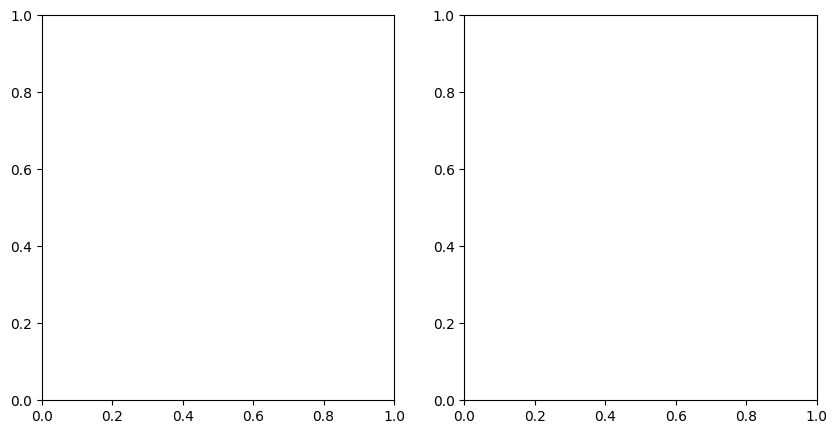

In [23]:
ts_unique_ens = len(ts_uplink_messages.node_id.unique())
ucb_unique_ens = len(ucb_uplink_messages.node_id.unique())
ts_cmap = mpl.cm.get_cmap('RdPu')
ucb_cmap = mpl.cm.get_cmap('PuBu')
xlim = 10
ylim = 10

fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

for i in range(0, ts_unique_ens):
    ts_data = ts_uplink_messages[ts_uplink_messages.node_id == ts_uplink_messages.node_id[i]]
    axis[0].plot(ts_data.x, ts_data.y, color=ts_cmap(i / ts_unique_ens))
    
for i in range(0, ucb_unique_ens):
    ucb_data = ucb_uplink_messages[ucb_uplink_messages.node_id == ucb_uplink_messages.node_id[i]]
    axis[1].plot(ucb_data.x, ucb_data.y, color=ucb_cmap(i / ucb_unique_ens))
    
# Add Access Point
axis[0].plot(xlim / 2, ylim / 2, '+', mew=10, ms=2, color='black')
axis[1].plot(xlim / 2, ylim / 2, '+', mew=10, ms=2, color='black')
# ax.plot(xlim / 2 + 5, ylim / 2 - 5, 'X', mew=10, ms=2, color='black')

for i in range(2):
    axis[i].set_xlim([0,xlim])
    axis[i].set_ylim([0,ylim])
    axis[i].spines['top'].set_visible(False)
    axis[i].spines['right'].set_color('#dddddd')
    axis[i].spines['left'].set_visible(False)
    axis[i].spines['bottom'].set_color('#dddddd')
    axis[i].tick_params(bottom=False, left=False)
    axis[i].set_axisbelow(True)
    axis[i].yaxis.grid(True, color='#eeeeee')
    axis[i].xaxis.grid(True, color='#eeeeee')
    axis[i].set_xlabel('X [km]', labelpad=15)
    axis[i].set_ylabel('Y [km]', labelpad=15)

axis[0].set_title('Paths of TS Nodes', pad=15)
axis[1].set_title('Paths of UCB Nodes', pad=15)

fig.tight_layout()

fig.savefig(f'ts-ucb-paths.{output_format}', dpi=300)

The End.